In [46]:
import pypulseq as pp
import numpy as np
import math

fov = 30e-3  # Define FOV and resolution
Nx = 128
Ny = Nx
alpha = 30  # Flip angle
slice_thickness = 0.8e-3  # Slice thickness
n_slices = 1
TE = 4.3e-3  # Echo time
TR = 20e-3  # Repetition time

rf_spoiling_inc = 117  # RF spoiling increment
ro_duration = 3.2e-3  # ADC duration

spoiler_duration = 3e-3  # Spoiler duration

# Set system limits
system = pp.Opts(
    max_grad=300,
    grad_unit='mT/m',
    max_slew=2000,
    slew_unit='T/m/s',
    rf_ringdown_time=20e-6,
    rf_dead_time=100e-6,
    adc_dead_time=10e-6,
    grad_raster_time=10e-6 # should be 8 ?
)

seq = pp.Sequence(system)  # Create a new sequence object


## Create events

In [47]:
rf, gz, _ = pp.make_sinc_pulse(
  flip_angle=alpha * np.pi / 180,
  duration=3e-3,
  slice_thickness=slice_thickness,
  apodization=0.5,
  time_bw_product=4,
  system=system,
  return_gz=True,
  delay=system.rf_dead_time,
)


# Define other gradients and ADC events
delta_k = 1 / fov
gx = pp.make_trapezoid(channel='x', flat_area=Nx * delta_k, flat_time=ro_duration, system=system)
adc = pp.make_adc(num_samples=Nx, duration=gx.flat_time, delay=gx.rise_time, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)
gz_reph = pp.make_trapezoid(channel='z', area=-gz.area / 2, duration=1e-3, system=system)
phase_areas = -(np.arange(Ny) - Ny / 2) * delta_k


In [48]:
# Gradient spoiling
gx_spoil = pp.make_trapezoid(channel='x', area=2 * Nx * delta_k,duration=spoiler_duration, system=system)
gz_spoil = pp.make_trapezoid(channel='z', area=4 / slice_thickness,duration=spoiler_duration, system=system)


In [49]:
# Calculate timing
delay_TE = (
    math.ceil(
        (TE - pp.calc_duration(gx_pre) - gz.fall_time - gz.flat_time / 2 - pp.calc_duration(gx) / 2)
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)
delay_TR = (
    math.ceil(
        (TR - pp.calc_duration(gz) - pp.calc_duration(gx_pre) - pp.calc_duration(gx) - delay_TE)
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)
assert np.all(delay_TE >= 0)
assert np.all(delay_TR >= pp.calc_duration(gx_spoil, gz_spoil))


# Start to create sequence blocks

In [50]:
seq = pp.Sequence(system)  # Create a new sequence object

rf_phase = 0
rf_inc = 0


# ======
# CONSTRUCT SEQUENCE
# ======
# Loop over slices
for s in range(n_slices):
    rf.freq_offset = gz.amplitude * slice_thickness * (s - (n_slices - 1) / 2)
    # Loop over phase encodes and define sequence blocks
    for i in range(Ny):
        rf.phase_offset = rf_phase / 180 * np.pi
        adc.phase_offset = rf_phase / 180 * np.pi
        rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]
        rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]

        seq.add_block(rf, gz)
        gy_pre = pp.make_trapezoid(
            channel='y',
            area=phase_areas[i],
            duration=pp.calc_duration(gx_pre),
            system=system,
        )
        seq.add_block(gx_pre, gy_pre, gz_reph)
        seq.add_block(pp.make_delay(delay_TE))
        seq.add_block(gx, adc)
        gy_pre.amplitude = -gy_pre.amplitude
        spoil_block_contents = [pp.make_delay(delay_TR), gx_spoil, gy_pre, gz_spoil]
        if i != Ny - 1:
            spoil_block_contents.append(pp.make_label(type='INC', label='LIN', value=1))
        else:
            spoil_block_contents.extend(
                [
                    pp.make_label(type='SET', label='LIN', value=0),
                    pp.make_label(type='INC', label='SLC', value=1),
                ]
            )
        seq.add_block(*spoil_block_contents)

## Check sequence

In [51]:
ok, error_report = seq.check_timing()

if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]


Timing check passed successfully


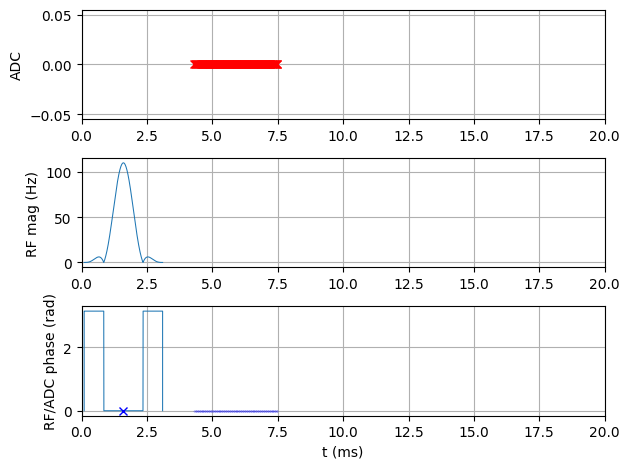

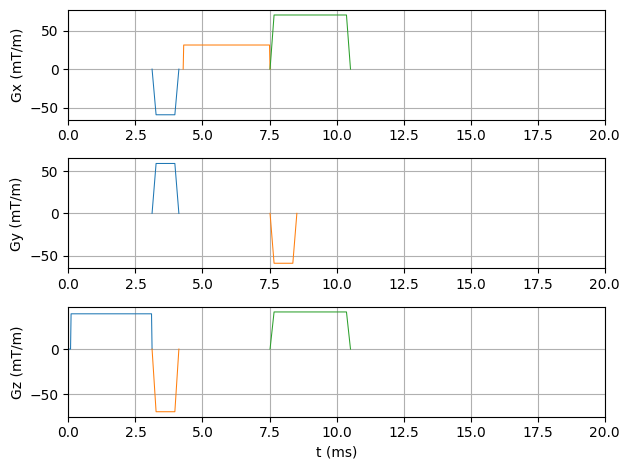

In [52]:
seq.plot(label='lin', time_range=np.array([0, 1]) * TR, time_disp='ms',grad_disp='mT/m')

# Write sequence to file

In [ ]:
# Prepare the sequence output for the scanner
# store all hyperparameters
# Systems
seq.set_definition(key='system_max_grad', value=system.max_grad)
seq.set_definition(key='system_grad_unit', value=system.grad_unit)
seq.set_definition(key='system_max_slew', value=system.max_slew)
seq.set_definition(key='system_slew_unit', value=system.slew_unit)
seq.set_definition(key='system_rf_ringdown_time', value=system.rf_ringdown_time)
seq.set_definition(key='system_rf_dead_time', value=system.rf_dead_time)
seq.set_definition(key='system_adc_dead_time', value=system.adc_dead_time)
seq.set_definition(key='system_grad_raster_time', value=system.grad_raster_time)

# geometry
seq.set_definition(key='FOV', value=[fov, fov, slice_thickness * n_slices])
seq.set_definition(key='matrix', value=[Nx, Ny, 1])
seq.set_definition(key='nslices', value=n_slices)

# contrast
seq.set_definition(key='alpha', value=alpha)
seq.set_definition(key='TE', value=TE)
seq.set_definition(key='TR', value=TR)

# remaining seq parameters
seq.set_definition(key='rf_spoiling_inc', value=rf_spoiling_inc)
seq.set_definition(key='ro_duration', value=ro_duration)
seq.set_definition(key='spoiler_duration', value=spoiler_duration)

seq.set_definition(key='Name', value='bruker_gre_label')
seq.write("out/bruker_gre_label")

'3ba6a4e4867176f912b12bc520aff5ba'